Гусев Владислав БПМИ187-1

In [141]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Populating the interactive namespace from numpy and matplotlib
Mounted at /content/drive


In [0]:
def dist(c1, c2):
    return ((c1 - c2)**2).sum()

In [0]:
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img // 4
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] += centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [0]:
def process_img(img_file, cut_func, centers, show=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers)
    penalty = get_penalty(img, classes, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

    return penalty

In [0]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [0]:
def get_penalty(img, classes, centers):
    assert len(centers) == 2
    result = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result += dist(img[x][y], centers[classes[x][y]])
    return result

In [0]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [0]:
import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path
def min_cut_max_flow(img, centers):
    assert len(centers) == 2
   
    G = nx.DiGraph()
   
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            G.add_edge('s',
                       (x, y),
                       capacity = np.sqrt(dist(img[x][y], centers[0])))
            G.add_edge((x, y),
                       't',
                       capacity = np.sqrt(dist(img[x][y], centers[1])))
           
            if y < img.shape[1]-1:
                G.add_edge((x, y),
                           (x, y+1),
                           capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x][y+1]))/255))
                G.add_edge((x, y+1),
                           (x, y),
                           capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x][y+1]))/255))
                if x < img.shape[0]-1:
                    G.add_edge((x, y),
                               (x+1, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
                    G.add_edge((x+1, y),
                               (x, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
            elif x < img.shape[0]-1:
                    G.add_edge((x, y),
                               (x+1, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
                    G.add_edge((x+1, y),
                               (x, y),
                               capacity = 1/(1+ np.sqrt(dist(img[x][y], img[x+1][y]))/255))
 
    cut_value, partition = nx.minimum_cut(G, 's', 't', flow_func=shortest_augmenting_path)
    classes = np.zeros_like(img[:, :, 0])

    for i in partition[0]:
        if i != 's' and i != 't':
            classes[i[0]][i[1]] = 1
           
    for i in partition[1]:
        if i != 's' and i != 't':
            classes[i[0]][i[1]] = 0
           
    return classes

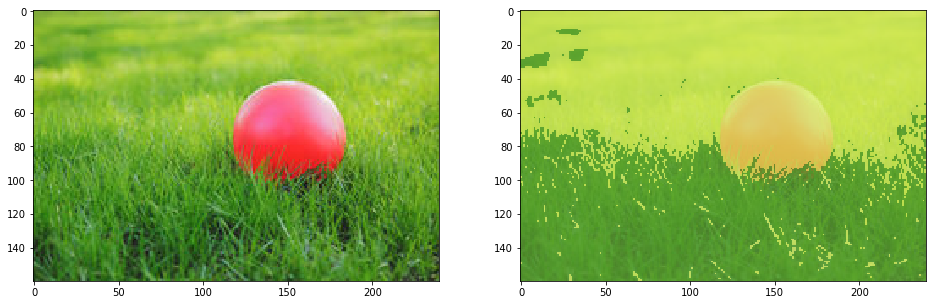

KeyboardInterrupt: ignored

In [124]:
for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/imgs/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, min_cut_max_flow, c, True)

In [0]:
#for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/DIPCO2016_dataset/*'):
#    process_img(img, min_cut_max_flow, [[0, 0, 0], [255, 255, 255]], True)
# Считается макисмально долго, что можно не дождаться)
# Поэтому не стал запускать в конечном варианте.

In [0]:
for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/imgs_multicolor/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, min_cut_max_flow, c, True)

Output hidden; open in https://colab.research.google.com to view.

Теперь напишу свою функцию:

In [0]:
#немного устал и тут могут быть ошибки, но вроде работает
def minimum_cut(graph, n):
    deff_cut = list()
    deff_cost = 1
    for i in range(14):
        deff_cost *= 10
    v = []
    w = []
    i = 0
    while (i < n):
        v.append([])
        i += 1
    i = 0
    while (i < n):
        v[i] = 1 * [i]
        i += 1
    exist = n * [1]
    in_a = n * [0]
    j = 0
    while (j < n - 1):
        in_a = n * [0]
        w = n * [0]
        bef = -1
        b = 0
        while (b < n - j):
            loc = -1
            i = 0
            while (i < n):
                if exist[i] and \
                   not in_a[i] and \
                   (loc == -1 or w[i] > w[loc]):
                    loc = i
                i += 1
            if b == n - j - 1:
                if w[loc] < deff_cost:
                    deff_cost = w[loc]
                    deff_cut = v[loc]
                v[bef].append(v[loc])
                i = 0
                while (i < n):
                    graph[bef][i] = graph[bef][i] + graph[loc][i]
                    graph[i][bef] = graph[i][bef] + graph[loc][i]
                    i += 1
                exist[loc] = 0
            else:
                in_a[loc] = 1
                i = 0
                while (i < n):
                    w[i] += graph[loc][i]
                    i += 1
                bef = loc
            j += 1
        j += 1
    return deff_cut

In [0]:
def new_cut_func(img, centers):
    assert len(centers) == 2
    Graph = list()
    classes = np.zeros_like(img[:, :, 0])
    for i in range(img.shape[0] * img.shape[1] + 1 + 1):
        Graph.append((img.shape[0] * img.shape[1] + 1 + 1) * [0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            temp1 = img.shape[0] * img.shape[1]
            temp2 = x * img.shape[1] + y
            Graph[temp1][temp2] = sqrt(dist(img[x][y],
                                            centers[0]))
            Graph[temp2][temp1 + 1] = sqrt(dist(img[x][y],
                                                centers[1]))
    for x in range(img.shape[0]):
        for y in range(img.shape[1] - 1):
            temp2 = x * img.shape[1] + y
            Graph[temp2][temp2 + 1] = 1 / (1 +
                                           sqrt(dist(img[x][y],
                                                     img[x][y + 1])) / 255)
            Graph[temp2 + 1][temp2] = 1 / (1 +
                                           sqrt(dist(img[x][y],
                                                     img[x][y + 1])) / 255)
    for x in range(img.shape[0] - 1):
        for y in range(img.shape[1]):
            temp2 = x * img.shape[1] + y
            temp3 = (x + 1) * img.shape[1] + y
            Graph[temp3][temp2] = 1 / (1 +
                                       sqrt(dist(img[x + 1][y],
                                                 img[x][y])) / 255)
            Graph[temp2][temp3] = 1 / (1 +
                                       sqrt(dist(img[x + 1][y],
                                                 img[x][y])) / 255) 
    partition = minimum_cut(Graph,
                            img.shape[0] * img.shape[1] + 1 + 1)
    for i in partition:
        x = i // img.shape[1]
        y = i % img.shape[1]
        if (x * img.shape[1] + y == img.shape[0] * img.shape[1]) or \
        (x * img.shape[1] + y == img.shape[0] * img.shape[1] + 1): 
            continue
        classes[x][y] = 1
    return classes

Saving imgonline-com-ua-Resize-f5UpuA58gJxEAcWh.jpg to imgonline-com-ua-Resize-f5UpuA58gJxEAcWh (3).jpg
Saving imgonline-com-ua-Resize-fyonPB25IDL.jpg to imgonline-com-ua-Resize-fyonPB25IDL (2).jpg
Saving imgonline-com-ua-Resize-pq6IT2cXCcb.jpg to imgonline-com-ua-Resize-pq6IT2cXCcb (2).jpg
Saving imgonline-com-ua-Resize-QPChaTCBEoZL.jpg to imgonline-com-ua-Resize-QPChaTCBEoZL (4).jpg
Saving imgonline-com-ua-Resize-RGjUByqi7SX4.jpg to imgonline-com-ua-Resize-RGjUByqi7SX4.jpg
Saving imgonline-com-ua-Resize-texgKu4jhZPLsz.jpg to imgonline-com-ua-Resize-texgKu4jhZPLsz (3).jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: numpy.hypot
  


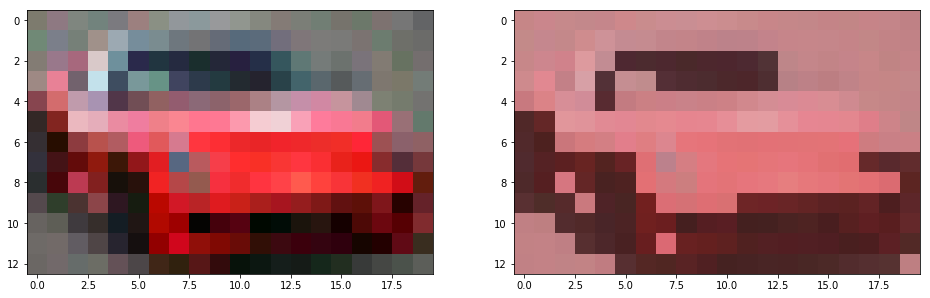

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: numpy.hypot
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: numpy.hypot
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: numpy.hypot
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: numpy.hypot
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: numpy.hypot
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: numpy.hypot


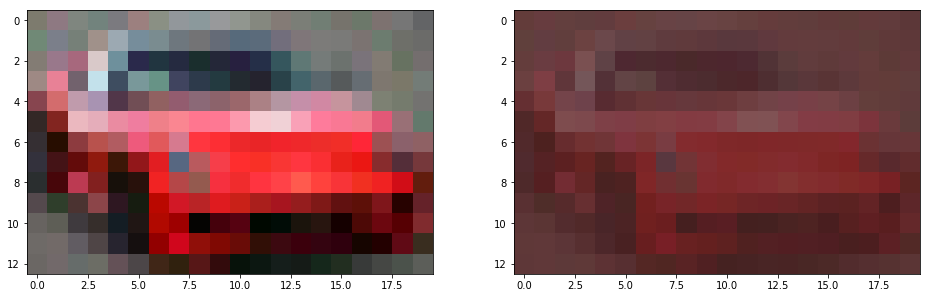

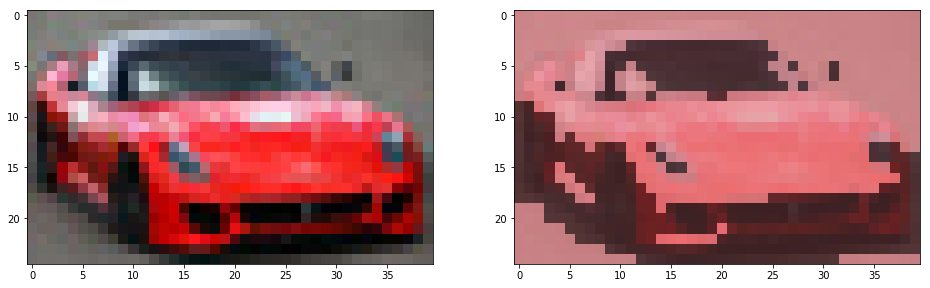

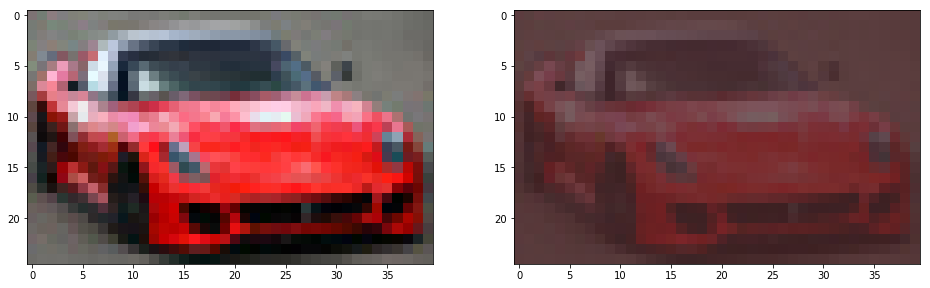

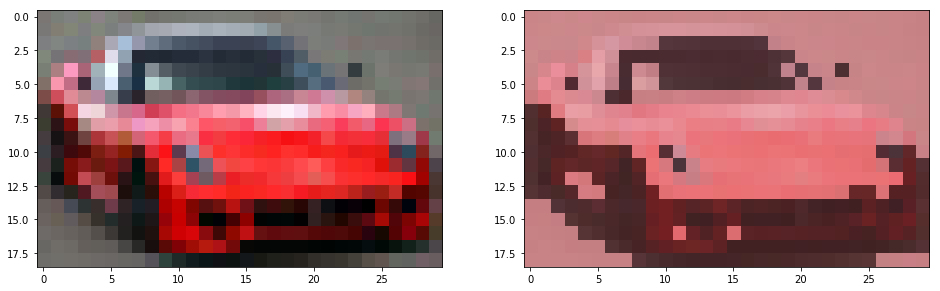

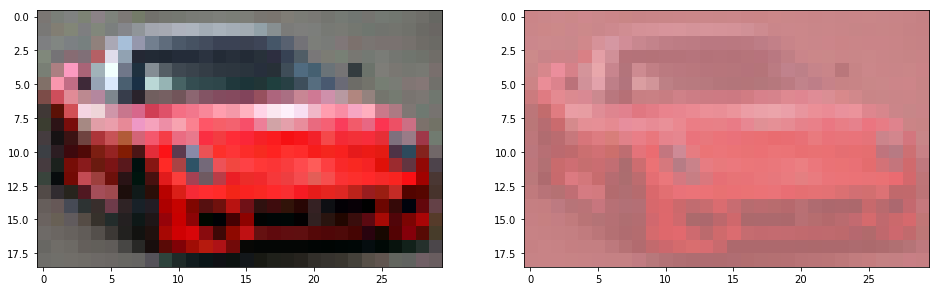

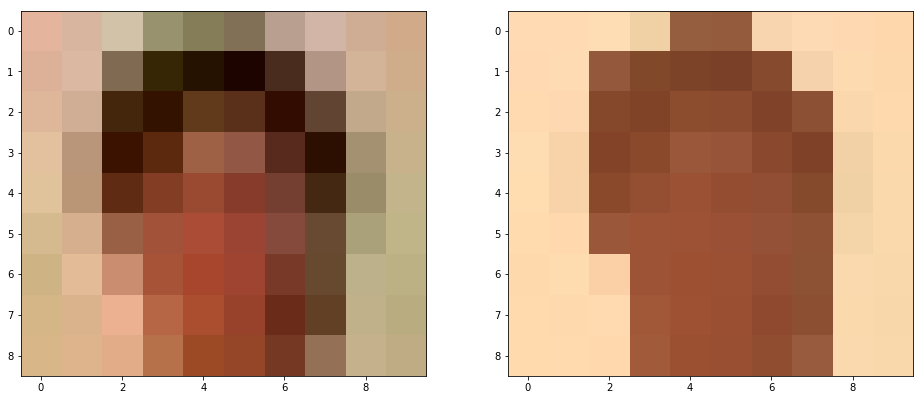

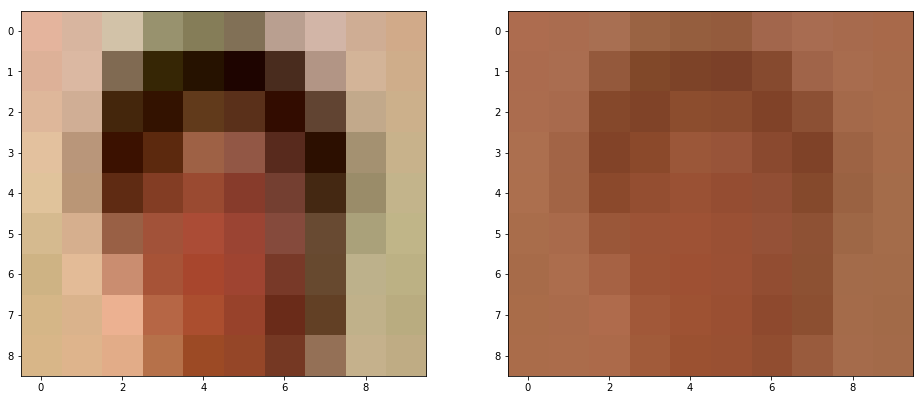

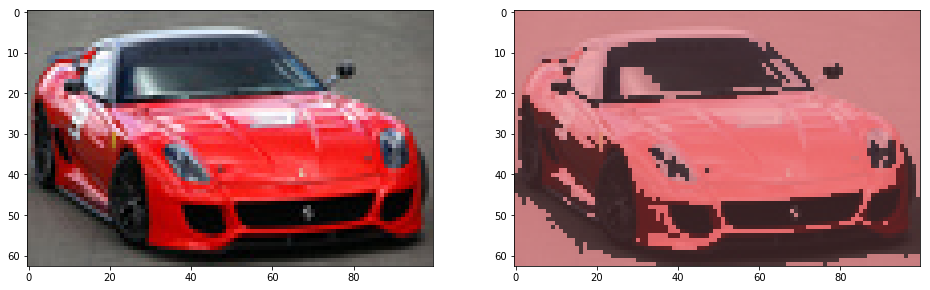

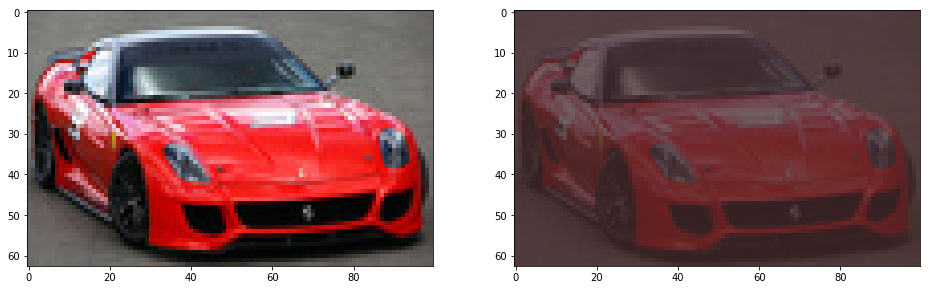

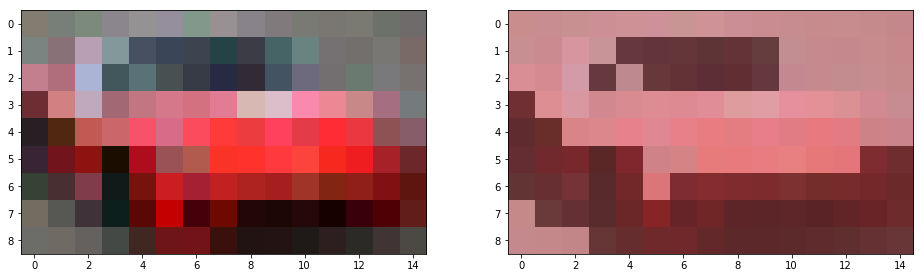

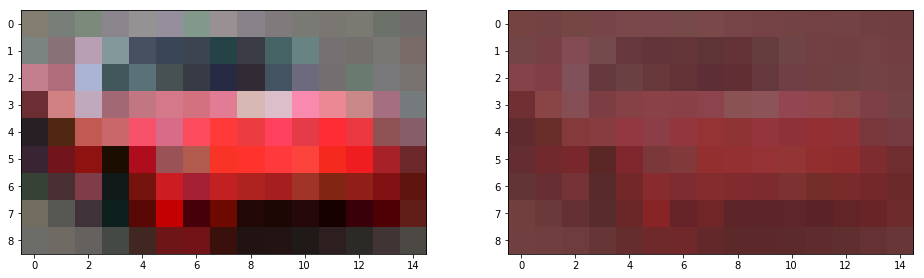

In [148]:
imgss = files.upload()
#for img in glob('/content/drive/My Drive/AiSd_labs/AiSd_lab_hw_2/my_tests/*'):
for img in imgss:
#    c = simple_get_centers(img)
#    process_img(img, simple_cut, c, True)
#    process_img(img, new_cut_func, c, True)
    c = simple_get_centers(img)
    process_img(img, simple_cut, c, True)
    process_img(img, new_cut_func, c, True)